# Hydrogen Atom

In the previous notebook, we solved the harmonic oscillator for 1 dimension using artifical neural networks.  In this notebook, we'll go a step further and solve a more complicated system (Hydrogen) in more dimensions (3 of course).  We will use more sophisticated sampling of the wavefunction and compute the proper $\nabla^2$ operator. 

In [1]:
import tensorflow as tf
import numpy

# What numerical precision?
# Note: float32 == single precision is OK for this notebook.  Higher order methods need float64 for a matrix inversion step.
DEFAULT_TENSOR_TYPE = tf.float32

# How many walkers should we use?
N_WALKERS = 200
# How many times should we make an observation of the observables each iteration?
N_OBSERVATIONS = 20

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

## Surrogate Wavefunction

For the hydrogen atom, we'll use a simple surrogate wavefunction.

NOTE that the wavefunction is a surrogate for $log \psi$, so the multiplicative initial boundary condition is a sum.

In [2]:
import numpy
import tensorflow as tf


class NeuralWavefunction(tf.keras.models.Model):
    """Create a neural network eave function in N dimensions

    Boundary condition, if not supplied, is gaussian in every dimension

    Extends:
        tf.keras.models.Model
    """
    def __init__(self, ndim : int):
        tf.keras.models.Model.__init__(self)

        self.ndim = ndim


        self.layer1 = tf.keras.layers.Dense(64, use_bias=False)
        self.layer2 = tf.keras.layers.Dense(64, use_bias=False)
        self.layer3 = tf.keras.layers.Dense(64, use_bias=False)
        self.layer4 = tf.keras.layers.Dense(64, use_bias=False)
        self.layer5 = tf.keras.layers.Dense(1, use_bias=False)

    @tf.function
    def call(self, inputs):
        # 
        # shape is [nwalkers, dim]
        
        x = self.layer1(inputs)
        x = tf.keras.activations.softplus(x)
        # WHat is softplus?  It's like ReLU at large absolute value, but is smooth through 0.0
        
        x = x + self.layer2(x)
        x = tf.keras.activations.softplus(x)

        x = x + self.layer3(x)
        x = tf.keras.activations.softplus(x)

        x = x + self.layer4(x)
        x = tf.keras.activations.softplus(x)
        
        # Just one output:
        x = self.layer5(x)
        # x = tf.keras.activations.tanh(x)

        # Compute the initial boundary condition, which the network will slowly overcome
        # This is important because it keeps the walkers bounded, otherwise they will not converge to a bound state.
        boundary_condition = -.1 * tf.reduce_sum(inputs**2, axis=(1))
        boundary_condition = tf.reshape(boundary_condition, [-1,1])

    
        return x + boundary_condition



In [3]:
wf = NeuralWavefunction(3)

## Metropolis Sampling

To sample the wave function, we'll use the metropolis algorithm.  We can implement this algorithm in tensorflow as shown below:

In [4]:

class MetropolisSampler(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    Relies on functional calls to sample on the fly with flexible distributions
    """
    def __init__(self,
        n           : int,
        nwalkers    : int,
        initializer : callable,
        init_params : iter ,
        dtype       = tf.float64):
        '''Initialize a metropolis sampler

        Create a metropolis walker with `n` walkers.  Can use normal, uniform

        Arguments:
            n {int} -- Dimension
            nwalkers {int} -- Number of unique walkers
            initializer {callable} -- Function to call to initialize each walker
            init_params {iter} -- Parameters to pass to the initializer, unrolled automatically
        '''

        # Set the dimension:
        self.n = n

        # Set the number of walkers:
        self.nwalkers = nwalkers

        self.size = (self.nwalkers, self.n)

        self.dtype = dtype

        #  Run the initalize to get the first locations:
        self.walkers = initializer(shape=self.size, **init_params, dtype=dtype)

    def sample(self):
        '''Just return the current locations

        '''
        # Make sure to wrap in tf.Variable for back prop calculations
        return  self.walkers

    def kick(self,
        wavefunction : tf.keras.models.Model,
        kicker : callable,
        kicker_params : iter,
        nkicks : int ):
        '''Wrapper for a compiled kick function via tensorflow.

        This fills in the compiled function with the size and the walkers.

        Arguments:
            wavefunction {tf.keras.models.Model} -- The wavefunction used for the metropolis walk
            kicker {callable} -- A callable function for generating kicks
            kicker_params {iter} -- Arguments to the kicker function.
        '''
        # for i in range(nkicks):
        walkers, acceptance = self.internal_kicker(
            self.size, self.walkers, wavefunction, kicker, kicker_params, tf.constant(nkicks), dtype=self.dtype)

        # Update the walkers:
        self.walkers = walkers

        # Send back the acceptance:
        return acceptance

    @tf.function
    def internal_kicker(self,
        shape,
        walkers,
        wavefunction : tf.keras.models.Model,
        kicker : callable,
        kicker_params : iter,
        nkicks : tf.constant,
        dtype):
        """Sample points in N-d Space

        By default, samples points uniformly across all dimensions.
        Returns a torch tensor on the chosen device with gradients enabled.

        Keyword Arguments:
            kicker {callable} -- Function to call to create a kick for each walker
            kicker_params {iter} -- Parameters to pass to the kicker, unrolled automatically
        """

        # Drop the model to reduced precision for this:
        # params = wavefunction.parameters()
        # print(params)

        # reduced_wf = tf.cast(wavefunction, dtype=self.dtype)
        # wavefunction.cast(self.dtype)


        # We need to compute the wave function twice:
        # Once for the original coordiate, and again for the kicked coordinates
        acceptance = tf.convert_to_tensor(0.0, dtype=dtype)
        # Calculate the current wavefunction value:
        current_wavefunction = wavefunction(walkers)

        # Generate a long set of random number from which we will pull:
        random_numbers = tf.math.log(tf.random.uniform(shape = [nkicks,shape[0],1], dtype=dtype))

        # Generate a long list of kicks:
        # print(shape)
        kicks = kicker(shape=[nkicks, *shape], **kicker_params, dtype=dtype)
        # print(kicks.shape)

        for i_kick in tf.range(nkicks):
            # Create a kick:
            kick = kicks[i_kick]
            # kick = kicker(shape=shape, **kicker_params, dtype=dtype)
            kicked = walkers + kick

            # Compute the values of the wave function, which should be of shape
            # [nwalkers, 1]
            kicked_wavefunction   = wavefunction(kicked)


            # Probability is the ratio of kicked **2 to original
            probability = 2 * (kicked_wavefunction - current_wavefunction)
            # Acceptance is whether the probability for that walker is greater than
            # a random number between [0, 1).
            # Pull the random numbers and create a boolean array
            # accept      = probability >  tf.random.uniform(shape=[shape[0],1])
            accept      = probability >  random_numbers[i_kick]
            # accept      = probability >  tf.math.log(tf.random.uniform(shape=[shape[0],1]))

            # Grab the kicked wavefunction in the places it is new, to speed up metropolis:
            current_wavefunction = tf.where(accept, kicked_wavefunction, current_wavefunction)

            # We need to broadcast accept to match the right shape
            # Needs to come out to the shape [nwalkers, nparticles, ndim]
            accept = tf.tile(accept, [1,tf.reduce_prod(shape[1:])])
            accept = tf.reshape(accept, shape)
            walkers = tf.where(accept, kicked, walkers)

            acceptance = tf.reduce_mean(tf.cast(accept, dtype))

        return walkers, acceptance

Now that we have a surrogate model and a sampling tool, we can test things:

In [5]:
sampler = MetropolisSampler(
            n           = 3, # 3 dimensions
            nwalkers    = N_WALKERS,
            initializer = tf.random.normal,
            init_params = {"mean": 0.0, "stddev" : 0.2},
            dtype       = DEFAULT_TENSOR_TYPE
    )

In [6]:
x = sampler.sample()

If we look at X, we should see a 100 x 3 tensor.  Elements from the tensor should roughly follow a gaussian distribution since that's what we used to initialize it (mean 0, STD 0.2)

In [7]:
print(x.shape)

(200, 3)


Now we can print a summary of the network, too:

In [8]:
values = wf(x)
wf.summary()
print(values.shape)

Model: "neural_wavefunction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  192       
_________________________________________________________________
dense_1 (Dense)              multiple                  4096      
_________________________________________________________________
dense_2 (Dense)              multiple                  4096      
_________________________________________________________________
dense_3 (Dense)              multiple                  4096      
_________________________________________________________________
dense_4 (Dense)              multiple                  64        
Total params: 12,544
Trainable params: 12,544
Non-trainable params: 0
_________________________________________________________________
(200, 1)


## Thermalize the walkers

To thermalize the walkers, we can "kick" them a number of times according to the metropolis algorithm:

In [9]:
acceptance = sampler.kick(
    wavefunction  = wf ,
    kicker        = tf.random.normal,
    kicker_params = {"mean": 0.0, "stddev" : 0.2},
    nkicks        = 5000 )
# This gets the latest walkers
x = sampler.sample()

In [10]:
print(acceptance)

tf.Tensor(0.905, shape=(), dtype=float32)


## Hydrogen Atom Hamiltonian

Here's an implementation of the hydrogen atom that computes observables:

In [11]:
import tensorflow as tf
import numpy

import logging
logger = logging.getLogger()


class HydrogenAtom(object):
    """Harmonic Oscillator Potential

    Implementation of the quantum harmonic oscillator hamiltonian
    """

    def __init__(self):
        ''' Initialize the Hamiltonian

        The derived class will check parameters, but this converts all of them to floats
        and scores as TF Constants.

        '''
        object.__init__(self)
        self.parameters = {"mass" : 1.0}
        # Cast them all to tf constants:
        for key in self.parameters:
            self.parameters[key] = tf.constant(float(self.parameters[key]),dtype=DEFAULT_TENSOR_TYPE)

        self.HBAR = tf.constant(1.0, dtype = DEFAULT_TENSOR_TYPE)
        self.ELECTRON_CHARGE = tf.constant(1.0, dtype = DEFAULT_TENSOR_TYPE)


    @tf.function
    def energy(self, wavefunction : tf.keras.models.Model, inputs : tf.Tensor):
        """Compute the expectation value of energy of the supplied wavefunction.

        Computes the integral of the wavefunction in this potential

        Arguments:
            wavefunction {Wavefunction model} -- Callable wavefunction object
            inputs {tf.Tensor} -- Tensor of shape [nwalkers, nparticles, dimension]

        Returns:
            tf.tensor - energy of shape [n_walkers]
            tf.tensor - energy_jf of shape [n_walkers]
            tf.tensor - ke_jf of shape [n_walkers]
            tf.tensor - ke_direct of shape [n_walkers]
            tf.tensor - pe of shape [n_walkers]
        """


        # This function takes the inputs
        # And computes the expectation value of the energy at each input point

        logw_of_x, dlogw_dx, d2logw_dx2 = self.compute_derivatives(wavefunction, inputs)

        pe, ke_jf, ke_direct = self.compute_energies(inputs, logw_of_x, dlogw_dx, d2logw_dx2)

        # Total energy computations:
        energy = tf.squeeze(pe+ke_direct)
        energy_jf = tf.squeeze(pe+ke_jf)

        return energy, energy_jf, ke_jf, ke_direct, pe

    
    @tf.function
    def compute_derivatives(self, wavefunction : tf.keras.models.Model, inputs : tf.Tensor):


        # Turning off all tape watching except for the inputs:
        # Using the outer-most tape to watch the computation of the first derivative:
        with tf.GradientTape(persistent=True) as tape:
            # Use the inner tape to watch the computation of the wavefunction:
            tape.watch(inputs)
            with tf.GradientTape() as second_tape:
                second_tape.watch(inputs)
                logw_of_x = wavefunction(inputs, training=True)
            # Get the derivative of logw_of_x with respect to inputs
            dlogw_dx = second_tape.gradient(logw_of_x, inputs)

        # Get the derivative of dlogw_dx with respect to inputs (aka second derivative)

        # We have to extract the diagonal of the jacobian, which comes out with shape
        # [nwalkers, dimension, dimension]

        # This is the full hessian computation:
        d2logw_dx2 = tape.batch_jacobian(dlogw_dx, inputs)

        
        # And this contracts:
        d2logw_dx2 = tf.einsum("wdd->wd",d2logw_dx2)

        return logw_of_x, dlogw_dx, d2logw_dx2
    
    @tf.function
    def potential_energy(self, *, inputs, Z):
        """Return potential energy

        If the potential energy is already computed, and no arguments are supplied,
        return the cached value

        If all arguments are supplied, calculate and return the PE.

        Otherwise, exception

        Arguments:
            inputs {tf.tensor} -- Tensor of shape [N, nparticles, dimension]
            Z {tf.tensor} -- Atomic number

        Returns:
            torch.Tensor - potential energy of shape [1]
        """

        # Potential energy is, for n particles, two pieces:
        # Compute r_i, where r_i = sqrt(sum(x_i^2, y_i^2, z_i^2)) (in 3D)
        # PE_1 = -(Z e^2)/(4 pi eps_0) * sum_i (1/r_i)
        # Compute r
        # Square the coordinates and sum for each walker
        r = tf.math.sqrt(tf.reduce_sum(inputs**2, axis=1))
        # This is the sum of 1/r for all particles with the nucleus:
        pe_1 = - (Z * self.ELECTRON_CHARGE**2 ) *  1. / (r + 1e-8)

        return pe_1
    
    @tf.function
    def kinetic_energy_jf(self, *, dlogw_dx, M):
        """Return Kinetic energy

        Calculate and return the KE directly

        Otherwise, exception

        Arguments:
            dlogw_of_x/dx {tf.Tensor} -- Computed derivative of the wavefunction

        Returns:
            tf.Tensor - kinetic energy (JF) of shape [1]
        """
        # < x | KE | psi > / < x | psi > =  1 / 2m [ < x | p | psi > / < x | psi >

        # Contract d2_w_dx over spatial dimensions and particles:
        ke_jf = (self.HBAR**2 / (2 * M)) * tf.reduce_sum(dlogw_dx**2, axis=(1))

        return ke_jf

    @tf.function
    def kinetic_energy(self, *, KE_JF : tf.Tensor, d2logw_dx2 : tf.Tensor, M):
        """Return Kinetic energy


        If all arguments are supplied, calculate and return the KE.

        Arguments:
            d2logw_dx2 {tf.Tensor} -- Computed second derivative of the wavefunction
            KE_JF {tf.Tensor} -- JF computation of the kinetic energy

        Returns:
            tf.Tensor - potential energy of shape [1]
        """

        ke = -(self.HBAR**2 / (2 * M)) * tf.reduce_sum(d2logw_dx2, axis=(1))
        ke = ke  - KE_JF

        return ke


    

    @tf.function
    def compute_energies(self, inputs, logw_of_x, dlogw_dx, d2logw_dx2):
        '''Compute PE, KE_JF, and KE_direct

        Harmonic Oscillator Energy Calculations

        Arguments:
            inputs {[type]} -- walker coordinates (shape is [nwalkers, nparticles, dimension])
            logw_of_x {[type]} -- computed wave function at each walker
            dlogw_dx {[type]} -- first derivative of wavefunction at each walker
            d2logw_dx2 {[type]} -- second derivative of wavefunction at each walker

        Raises:
            NotImplementedError -- [description]

        Returns:
            pe -- potential energy
            ke_jf -- JF Kinetic energy
            ke_direct -- 2nd deriv computation of potential energy
        '''

        # Potential energy depends only on the wavefunction
        pe = self.potential_energy(inputs=inputs, Z=1)

        # KE by parts needs only one derivative
        ke_jf = self.kinetic_energy_jf(dlogw_dx=dlogw_dx, M=self.parameters["mass"])

        # True, directly, uses the second derivative
        ke_direct = self.kinetic_energy(KE_JF = ke_jf, d2logw_dx2 = d2logw_dx2, M=self.parameters["mass"])


        return pe, ke_jf, ke_direct



In [12]:
hamiltonian = HydrogenAtom()

In [13]:
energy, energy_jf, ke_jf, ke_direct, pe = hamiltonian.energy(wf, x)

In [14]:
print(tf.reduce_mean(energy))

tf.Tensor(-0.27865386, shape=(), dtype=float32)


In the units we're using (atomic units) the value of the hydrogen ground state comes out to -0.5.  So, this is good: the energy is above the ground state for our random wavefunction which is good!

## Optimizing the wavefunction

To optimize the wavefunction, we'll need to compute several observables based on the jacobian.  Here are some functions to help contained within a `compute_gradients` function.

In [15]:
def compute_gradients(N_OBSERVATIONS, sampler, wavefunction, hamiltonian):

    # Helper function to compute jacobians:
    @tf.function
    def jacobian(x_current, wavefunction):
        tape = tf.GradientTape()

        with tape:
            tape.watch(wavefunction.trainable_variables)
            log_wpsi = wavefunction(x_current)

    #     print(log_wpsi)


        jac = tape.jacobian(log_wpsi, wavefunction.trainable_variables)

    #     print(wavefunction.trainable_variables)
    #     print(jac)

        # Grab the original shapes ([1:] means everything except first dim):
        jac_shape = [j.shape[1:] for j in jac]
        # get the flattened shapes:
        flat_shape = [[-1, tf.reduce_prod(js)] for js in jac_shape]
        # Reshape the

        # We have the flat shapes and now we need to make the jacobian into a single matrix

        flattened_jacobian = [tf.reshape(j, f) for j, f in zip(jac, flat_shape)]

        flattened_jacobian = tf.concat(flattened_jacobian, axis=-1)

        return flattened_jacobian, flat_shape


    # Helper function to compute observables:
    @tf.function
    def compute_O_observables(flattened_jacobian, energy):

        # dspi_i is the reduction of the jacobian over all walkers.
        # In other words, it's the mean gradient of the parameters with respect to inputs.
        # This is effectively the measurement of O^i in the paper.
        dpsi_i = tf.reduce_mean(flattened_jacobian, axis=0)
        dpsi_i = tf.reshape(dpsi_i, [-1,1])

        # Computing <O^m H>:
        dpsi_i_EL = tf.linalg.matmul(tf.reshape(energy, [1,N_WALKERS]), flattened_jacobian)
        # This makes this the same shape as the other tensors
        dpsi_i_EL = tf.reshape(dpsi_i_EL, [-1, 1])

        return dpsi_i, dpsi_i_EL

    
    dpsi_i = None
    dpsi_i_EL = None
    obs_energy = 0
    
    for i_obs in range(N_OBSERVATIONS):
    
        # First, we kick the sampler to re-thermalize to the new wavefunction:
        kicker = tf.random.normal
        kicker_params = {"mean": 0.0, "stddev" : 0.4}

        acceptance = sampler.kick(wf, kicker, kicker_params, nkicks=100)


        # Get the current walker locations:
        x_current  = sampler.sample()

        # Compute the observables:
        energy, energy_jf, ke_jf, ke_direct, pe = hamiltonian.energy(wf, x_current)

        energy /= N_WALKERS


        # For each observation, we compute the jacobian.
        # flattened_jacobian is a list, flat_shape is just one instance
        flattened_jacobian, flat_shape = jacobian(x_current, wf)

        _dpsi_i, _dpsi_i_EL = compute_O_observables(flattened_jacobian, energy)
        if dpsi_i is None:
            dpsi_i = _dpsi_i
        else:
            dpsi_i += _dpsi_i
            
        if dpsi_i_EL is None:
            dpsi_i_EL = _dpsi_i_EL
        else:
            dpsi_i_EL += _dpsi_i_EL

        obs_energy += tf.reduce_sum(energy)
        
    obs_energy /= N_OBSERVATIONS
    dpsi_i     /= N_OBSERVATIONS
    dpsi_i_EL  /= N_OBSERVATIONS
    
    
    gradients = - 2*( dpsi_i * obs_energy - dpsi_i_EL )

    # Lastly, reshape the gradients to match the weights:
    running_index = 0
    gradient = []
    for length in flat_shape:
        l = length[-1]
        end_index = running_index + l
        gradient.append(gradients[running_index:end_index])
        running_index += l
    
    shapes = [ p.shape for p in wf.trainable_variables ]
    gradients = [ tf.reshape(g, s) for g, s in zip(gradient, shapes)]
    return gradients, obs_energy

## Optimization Loop

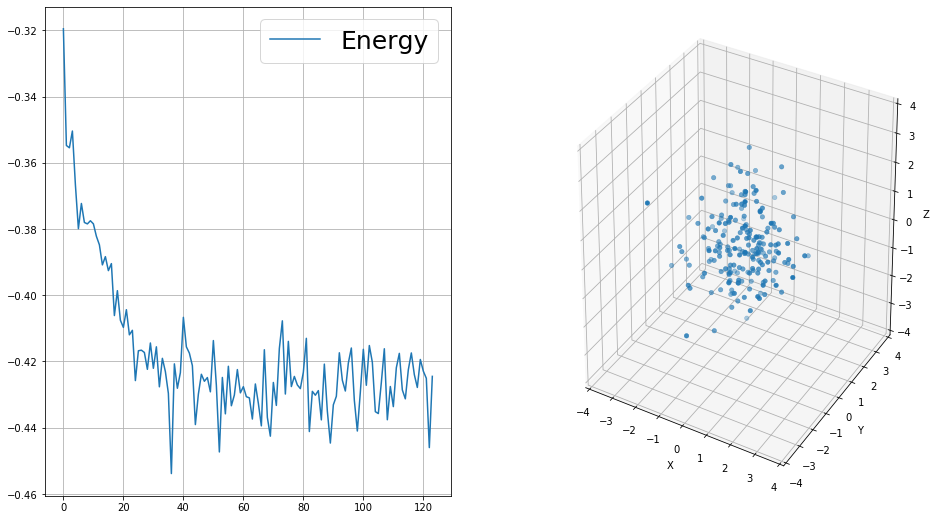

In [ ]:


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.5)



# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(16,9))
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_denst  = plt.subplot(gs[:,1], projection="3d")

energy_history = []
steps_history  = []

for i in range(500):
    
    gradients, energy = compute_gradients(N_OBSERVATIONS, sampler, wf, hamiltonian)
    
    optimizer.apply_gradients(zip(gradients, wf.trainable_variables))
    
    energy_history.append(energy)
    steps_history.append(i)

    # Here we update the plots.  Show the energy function:
    ax_loss.set_xlim(0, 1.1*i)
    ax_loss.cla()
    ax_loss.plot(steps_history, energy_history, label="Energy")
    ax_loss.grid(True)
    ax_loss.legend(fontsize=25)

    # Show the location of the walkers:
    x, y, z = tf.split(sampler.sample(), 3, axis=1)
    ax_denst.clear()
    ax_denst.set_xlim(-4,4); ax_denst.set_ylim(-4,4); ax_denst.set_zlim(-4,4);
    ax_denst.set_xlabel("X"); ax_denst.set_ylabel("Y"); ax_denst.set_zlabel("Z");
    ax_denst.scatter(x, y, z, linewidth=0.5);

    display(fig)
    clear_output(wait = True)
    plt.pause(0.25)
    
    